In [1]:
import scipy.stats as stats
import math
from scipy.stats import kruskal
import pandas as pd

from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import seaborn as sns

from sklearn.metrics import pairwise_distances_argmin_min ,r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

#from pmdarima import auto_arima

In [2]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem1.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,565857,84879,ASSORTED COLOUR BIRD ORNAMENT,16,9/7/2011 14:13,1.69,14911.0,EIRE
1,560452,22432,WATERING CAN PINK BUNNY,6,7/19/2011 9:51,1.95,12682.0,France
2,578509,22492,MINI PAINT SET VINTAGE,36,11/24/2011 13:17,0.65,12705.0,Germany
3,579345,22728,ALARM CLOCK BAKELIKE PINK,8,11/29/2011 11:46,3.75,12727.0,France
4,564039,21731,RED TOADSTOOL LED NIGHT LIGHT,12,8/22/2011 12:40,1.65,12645.0,Germany


In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['date'] = df['InvoiceDate'].dt.date

df['price'] = df['Quantity'] * df['UnitPrice']

##### **1.1 EDA, 이상치 제거 후 F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 탐색적 분석 실시**

In [4]:
# 1. 이상치 제거 
# 인보이스 C (취소건) 삭제 및 Qaunity _ Price 확인 

buy = df[df['InvoiceNo'].str[0] != 'C'].reset_index(drop = True)

# Recency
# 기준일: 데이터의 최종 거래일 + 1일
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = buy.groupby('CustomerID').agg(
    {'InvoiceDate' : lambda x : (ref_date - x.max()).days , 
     'InvoiceNo' : 'nunique' , 
     'price' : 'sum'
        
    }
)
rfm

,InvoiceDate,InvoiceNo,price
CustomerID,,,
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
12352.0,36,8,2506.04
12354.0,232,1,1079.40
...,...,...,...
14935.0,297,1,1784.71
14936.0,34,8,8137.02
14937.0,57,3,1621.88


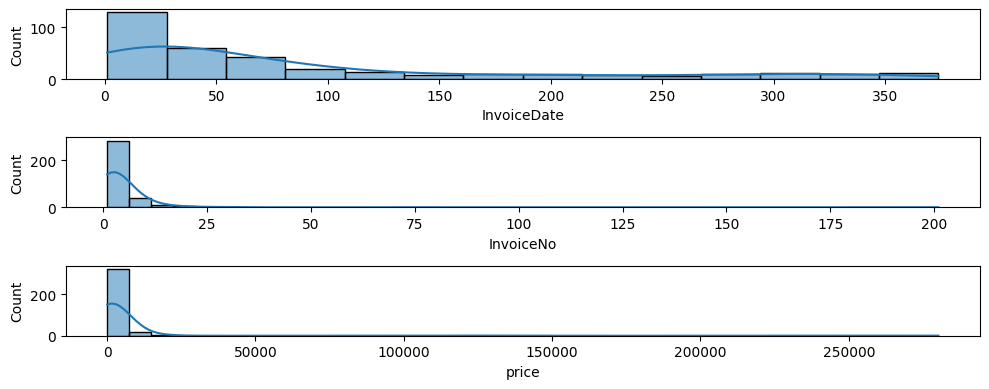

In [5]:
# 탐색적 분석 실시 
fig,axes = plt.subplots(3,1, figsize = (10, 4))
for axes, col in zip(axes.flatten(), rfm.columns) : 
    sns.histplot(rfm[col], kde = True, ax = axes)

plt.tight_layout()
plt.show()

##### 1.2 F, M feature 기반으로 군집분석 실시

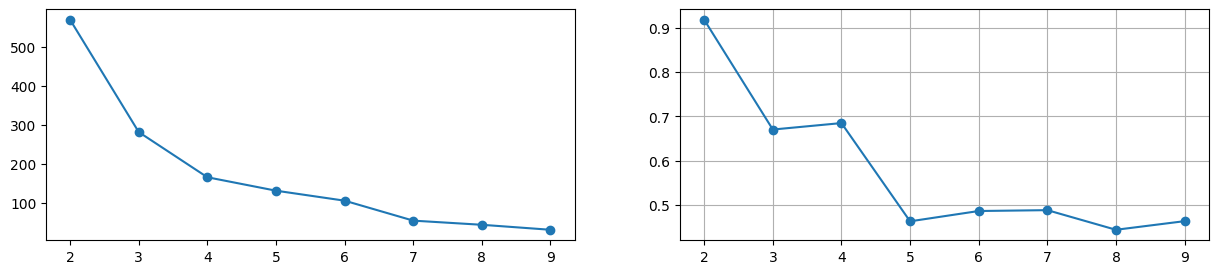

In [6]:
from sklearn.metrics import silhouette_score

rfm = pd.DataFrame(StandardScaler().fit_transform(rfm), columns = rfm.columns)

iner = []
sil = []
for k in range(2, 10) : 
    km = KMeans(n_clusters= k, random_state= 42)
    km.fit(rfm)
    iner.append(km.inertia_)
    sil.append(silhouette_score(rfm, km.labels_))

fig, axes = plt.subplots(1,2, figsize = (15,3))
axes[0].plot(range(2 ,10), iner, marker = 'o')
axes[1].plot(range(2, 10), sil, marker = 'o')

plt.grid()

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

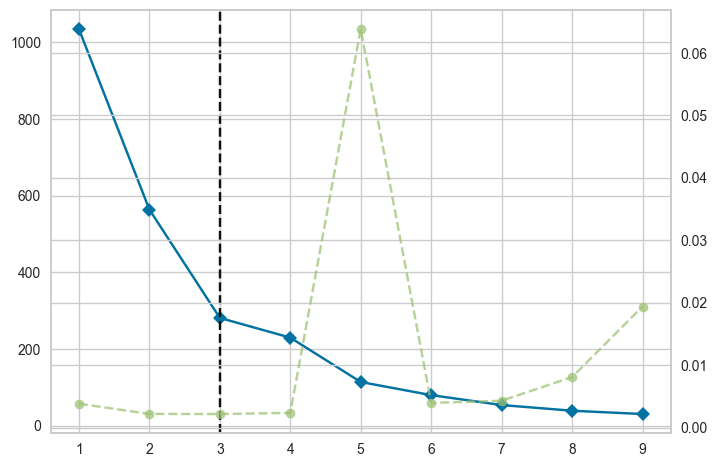

In [7]:
from yellowbrick.cluster import KElbowVisualizer
kmean = KMeans()
visual = KElbowVisualizer(kmean, k=(1, 10))
visual.fit(rfm)

##### 1.3 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술

In [8]:
print('''
응집도 
    데이터들이 얼마나 가까이 있는지에 대한 설명, 군집 내 분산(inertia)가 낮을 수록 좋은 응집도
분리도 
    군집들 간의 거리가 얼마나 명확한가, 군집 간의 중심 거리가 크고, 겹침이 없을때, 

''')

# 응집도- inertia 를 뽑아보기
km3 = KMeans(n_clusters=3)
km3.fit(rfm)
print(km3.inertia_)

# 분리도 : 각 군집의 평균간 거리 
cluster = km3.cluster_centers_

mat = pairwise_distances_argmin_min(cluster, rfm[['InvoiceDate', 'InvoiceNo', 'price']])[1]
print(sum(mat) / len(mat))


응집도 
    데이터들이 얼마나 가까이 있는지에 대한 설명, 군집 내 분산(inertia)가 낮을 수록 좋은 응집도
분리도 
    군집들 간의 거리가 얼마나 명확한가, 군집 간의 중심 거리가 크고, 겹침이 없을때, 


281.0100662849815
2.1191167463443255


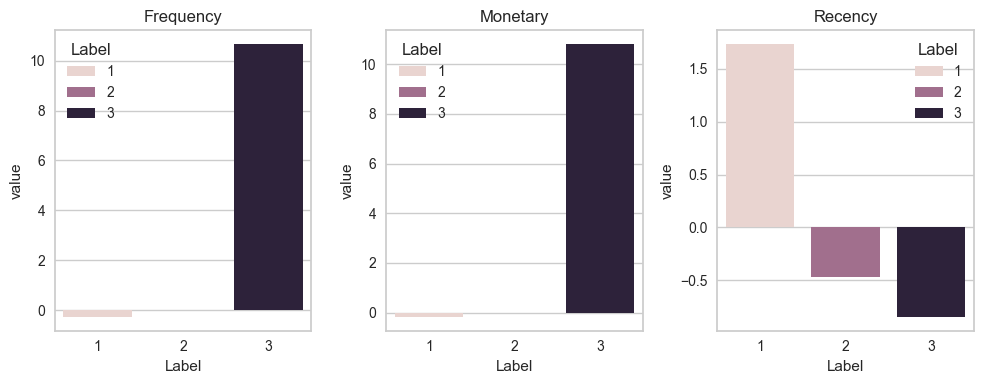

In [9]:
rfm['label']= km3.labels_ + 1
rfm.columns = ['Recency' ,'Frequency' ,'Monetary','Label']

fig,axes = plt.subplots(1,3, figsize = (10, 4))
for axes, col in zip(axes.flatten(), rfm.columns.difference(['Label'])) : 
    target = rfm.groupby('Label')[col].mean().reset_index(name = 'value')
    sns.barplot(data = target, x = target.Label, y = target.value , hue = target.Label, ax = axes)
    axes.set_title(col)

plt.tight_layout()
plt.show()

##### **2. 시계열 분석**
- 2.1 EDA와 시각화를 진행하라
- 2.2 결측치 처리와 해당 결측치 처리 방식에 대한 논리적 근거를 제시하라
- 2.3 계절성을 반영한 시계열 모델을 제시하고 정확도 측면에서 모델 성능 평가 할 것
- 2.4 분석 결과 활용 가능 여부에 대한 분석 전문가로서의 제안

In [18]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem2.csv',index_col = 0)
df.head()

,counts
0,544.3
1,603.1
2,NaN
3,533.4
4,619.5


<Axes: >

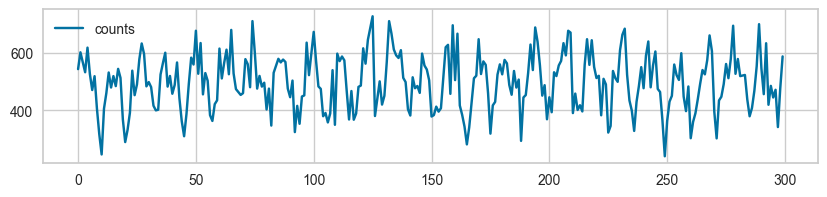

In [19]:
df['pseudo_month'] =pd.date_range(start='2023-01-01',end ='2100-01-01', freq='MS')[:300]

# 시각화
fig,ax = plt.subplots(1,figsize=(10,2))
sns.lineplot(df, ax = ax)

In [20]:
#  결측치 처리와 해당 결측치 처리 방식에 대한 논리적 근거를 제시
print('''
1. 선형 보간법 - 시간에 따른 자연스러운 흐름을 가정할때 적절 
2. 이동평균/이웃 기반 방식 
''')

df1 = df.copy()
shift = (df1.counts.shift() + df1.counts.shift(-1)) / 2 
df1['counts'] = df1['counts'].fillna(shift)

df_inter = df.copy()
df_inter['counts'] = df_inter['counts'].interpolate(method='linear')


1. 선형 보간법 - 시간에 따른 자연스러운 흐름을 가정할때 적절 
2. 이동평균/이웃 기반 방식 



In [21]:
# 2.3 계절성을 반영한 시계열 모델을 제시하고 정확도 측면에서 모델 성능 평가 할 것 

print('''
1. SARIMA (Seasonal ARIMA) - 기존 모형에 계절성 모형을 추가 
    SARIMA(p,d,q)s : s는 계절 주기 
2. Holt-Winters 지수평활법 
    단순 지수평활에 추가 + 계절성 반영
    
모델의 성능 평가는 시계열 분할 검증을 통해 수행하며, RMSE, MAE, MAPE와 같은 오차 지표를 사용한다. 
지표 값이 작을수록 예측 정확도가 높음을 의미한다. 따라서 계절성이 존재하는 시계열에서는 계절 모형을 선택하고, 
예측 오차 지표로 그 성능을 객관적으로 평가하는 것이 바람직
''')


1. SARIMA (Seasonal ARIMA) - 기존 모형에 계절성 모형을 추가 
    SARIMA(p,d,q)s : s는 계절 주기 
2. Holt-Winters 지수평활법 
    단순 지수평활에 추가 + 계절성 반영

모델의 성능 평가는 시계열 분할 검증을 통해 수행하며, RMSE, MAE, MAPE와 같은 오차 지표를 사용한다. 
지표 값이 작을수록 예측 정확도가 높음을 의미한다. 따라서 계절성이 존재하는 시계열에서는 계절 모형을 선택하고, 
예측 오차 지표로 그 성능을 객관적으로 평가하는 것이 바람직



In [22]:
from scipy import interpolate  # 결측치 - 보간법

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf

# 시계열 시각화
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import itertools

0.00661501053959763


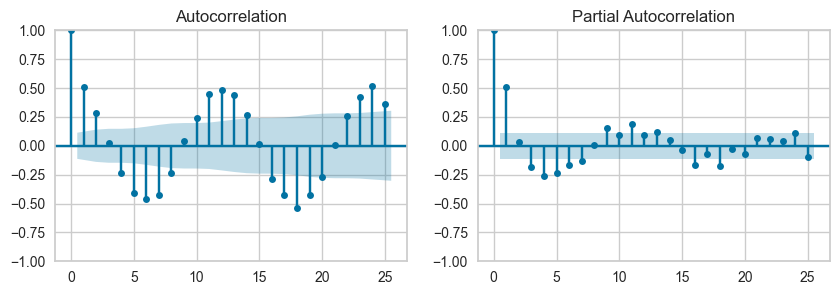


ACF - 보통 빠르게 0에 수렴 
      보여지는 데이터로는 비정상성 > 차분이 필요 , 추세나 계정성이 남아있음 
PACF = Lag 1이후로는 빠르게 감소 AR(1)




In [23]:
# 정규성 검토

# 귀무 : 비정상
# 대립 : 정상 
ad = adfuller(df1.counts, regression = 'C', autolag = 'AIC')
print(ad[1])

fig, ax = plt.subplots(1,2, figsize=(10,3))
plot_acf(df1.counts, ax=ax[0])
plot_pacf(df1.counts, ax=ax[1])
plt.show()

print('''
ACF - 보통 빠르게 0에 수렴 
      보여지는 데이터로는 비정상성 > 차분이 필요 , 추세나 계정성이 남아있음 
PACF = Lag 1이후로는 빠르게 감소 AR(1)

''')

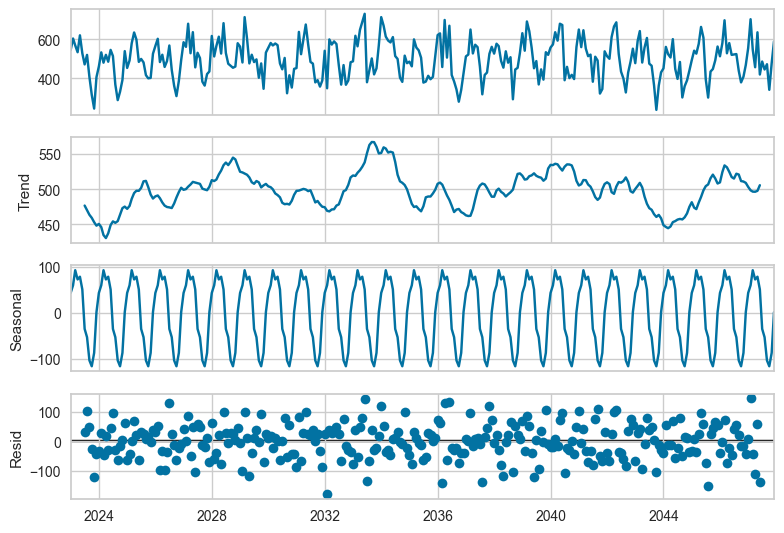

In [24]:
# 2) 시계열 분해
df1 = df1.set_index('pseudo_month')
d = sm.tsa.seasonal_decompose(df1)
d.plot()
plt.show()

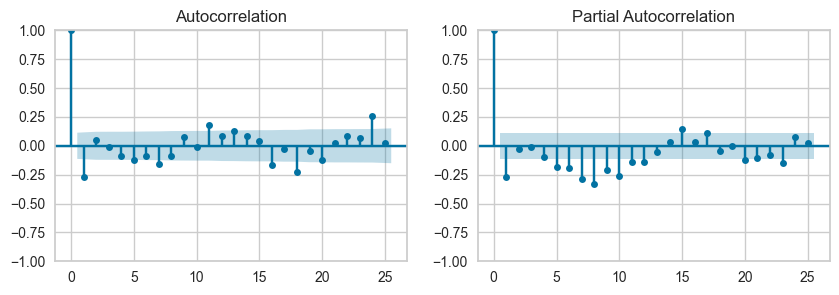

In [25]:
df1['diff'] = df1['counts'].diff()
ts = df1['diff'].dropna()

fig, ax = plt.subplots(1,2, figsize=(10,3))
plot_acf(ts, ax=ax[0])
plot_pacf(ts, ax=ax[1])
plt.show()

In [26]:
train = df1.iloc[:276]
test = df1.iloc[-24:]

#auto_arima(train, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7,
#           seasonal=True, trace=False, error_action='warn', suppress_warnings=True)  

```python
# 계절성을 반영한 시계열 모델을 위해 SARIMA 모델을 제시
# 정확도 측정 : RMSE, MAPE, MAE, R2_score 지표로 성능 비교
from sklearn.metrics import mean_absolute_error , mean_squared_error
import numpy as np

sarima_model = auto_arima(train, order = (1, 0, 0), seasonal_order = (1,0,0,7))

sari_pred = sarima_model.predict(n_periods = len(test))

mae = mean_absolute_error(test, sari_pred)
rmse = np.sqrt(mean_squared_error(test, sari_pred))
mape = np.mean(np.abs((test - sari_pred) / test)) * 100

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

plt.figure(figsize=(10, 4))

plt.plot(test.index, test, label = 'Actual', color = 'black')
plt.plot(test.index, sari_pred, label = 'Prediction', color = 'blue')
plt.title('Actual vs  SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()
```

##### 통계1) 연매출이 3000, 4000, 5000이었다면 연평균 몇배가 증가

In [27]:
y2= 3000
y1 = 4000
y0 = 5000 
# 현재 - 과거 / 과거 
g1 = (y1 - y2) / y2
g2 = (y0 - y1) / y1 

print((g1 + g2) / 2 * 100)

# CAGR - (최종/초기)** (1/기간)
((y0/y2) ** (1/2 ) - 1) * 100

29.166666666666664


29.09944487358056

통계 2)표본 10개의 분산이 90일 때 신뢰도 95%로 모분산의 신뢰구간을 추정 - 카이제곱 분포

In [28]:
from scipy import stats
n = 10 
var = 90
df = n -1
confa = 0.05

cr1 = stats.chi2.ppf(1 - confa /2, df)
cr2 = stats.chi2.ppf(confa/2 , df) 

c1 = (df * var) / cr1 
c2 = (df * var) / cr2
print(c1, c2)

42.58055444790953 299.9567284667237


통계 3) X, Y, Z 공장별 중위수 차이가 존재하는가

In [29]:
import pandas as pd
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem5.csv',encoding='cp949')
df.head()

,출하 소요시간,공장명,공장별 출하 소요시간 순위
0,71,Z,11
1,75,X,14
2,71,X,12
3,53,Z,1
4,50,X,1


In [33]:
from scipy.stats import kruskal

g = [group['출하 소요시간'] for name, group in df.groupby('공장명')]
stat, p_val = kruskal(*g)
print(p_val)

0.6970526702392181
